# Анализ кластеров за 2016 год

In [1]:
import json
import numpy as np
from itertools import groupby
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import spatial

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import datetime
from matplotlib.dates import MO
from random import shuffle
import time

%matplotlib notebook

In [34]:
import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt


class HistResult:
    # Матрица с результатами, в виде списка таплов: (mi, ln_mi, variance, ln_variance)
    matrix = []
    
    # коэффициет b
    x = []
    y = []
    
    
    def __regress(self, x, y):
        slope, intercept, correlation_coefficient, p_value, std_err = stats.linregress(x,y)
        h = (2 - slope) / 2
        
        return (slope, intercept, correlation_coefficient, h)
    
    def __init__(self, matrix, x, y):
        self.matrix = matrix
        self.x = x
        self.y = y
        
    def print_result(self): 
        print("---")
        for mi, ln_mi, variance, ln_variance in self.matrix:
            print("mi: 1/%s, variance: %s, ln(variance): %s, ln(m): %s)" % (mi, variance, ln_variance, ln_mi))
            
    def plot(self, height = 5, width = 10, font_size = 12):
        plt.rcParams['figure.figsize'] = (width, height)
        plt.rcParams['font.size'] = font_size
        
        fig, ax = plt.subplots()
        
        x1 = []
        y1 = []
        
        ax.scatter(self.x, self.y)
        
        print("==1==")
        slope, intercept, correlation_coefficient, h = self.__regress(self.x[0:5], self.y[0:5])
        print ("y = %s * x + %s" %(slope, intercept))
        print("correlation coefficient: %s" % correlation_coefficient)
        print("h=%s" % h)
    
        for xx in np.arange(min(self.x) - 0.1, max(self.x) + 0.1, 0.1):
            x1.append(xx)
            y1.append(slope * xx + intercept)
        
        ax.plot(x1, y1)
        
        x1 = []
        y1 = []
        
        print("==2==")
        slope, intercept, correlation_coefficient, h = self.__regress(self.x[5:], self.y[5:])
        print ("y = %s * x + %s" %(slope, intercept))
        print("correlation coefficient: %s" % correlation_coefficient)
        print("h=%s" % h)
        
        for xx in np.arange(min(self.x) - 0.1, max(self.x) + 0.1, 0.1):
            x1.append(xx)
            y1.append(slope * xx + intercept)
        
        ax.plot(x1, y1)
        
        fig.show()

class SelfSimilarityHirst:
    """
        Самоподобие Херста
    """
    
    def __blocks_split(self, arr, size):
        """
            Делит входной массив на блоки указанного размера,
            например arr = [1, 2, 3, 4, 5], size = 2,
            результат: [[1, 2], [3, 4]]
            отбрасывает элементы для которых не хватает блоков
        """
        blocks = []
        pos = 0
        for i in range(size, len(arr) + 1, size):
            blocks.append(arr[pos:i])
            pos = pos + size
        return blocks

    def __expected_value(self, arr):
        """
            Математическое ожидание (среднее)
        """
        return sum(arr) / len(arr)

    def __variance(self, arr, exp):
        """
            Дисперсия
        """
        d = [math.pow(x - exp, 2) for x in arr]
        return sum(d) / len(d)
    
    def __block_count(self, data_len):
        """
            Рассчитывает количество блоков
        """
        return int(data_len / 2)
    
    def __variance_matrix(self, data, log_base):
        """
            Рассчитывает зависимость логарифма среднего значения дисперсии от логарифма mi
        """
        result = []
        
        last_cnt = -1
        
        block_count = self.__block_count(len(data))
        
        for mi in range(block_count, 0, -1):
            block_cnt = int(len(data)/mi)
            
            # Если уже были блоки такого размера, то пропускаем
            if block_cnt == last_cnt:
                continue
            last_cnt = block_cnt
            
            dds = []
            
            # Рассчет среднего и дисперсии для каждого блока
            for block in self.__blocks_split(data, block_cnt):
                vals = [y for x, y in block]
                ev = self.__expected_value(vals)
                v = self.__variance(vals, ev)
                dds.append(v)
               
            # Рассчет среднего значения дисперсий блока
            variance = self.__expected_value(dds)
            
            ln_mi = math.log(1/mi, log_base)
            ln_variance = math.log(variance, log_base)
            
            result.append((mi, ln_mi, variance, ln_variance))
            
        return result
    
    def __regress(self, x, y):
        slope, intercept, correlation_coefficient, p_value, std_err = stats.linregress(x,y)
        h = (2 - slope) / 2
        
        return (slope, intercept, correlation_coefficient, h)
    
    def compute(self, data, log_base = math.e):
        matrix = self.__variance_matrix(data, log_base)
        
        x = [x[1] for x in matrix]
        y = [y[3] for y in matrix]
        
        return HistResult(matrix, x, y)

In [3]:
class News:
    def __init__(self, id, date, title, content, url, siteType):
        self.id = id
        self.date = date
        self.title = title
        self.content = content
        self.url = url
        self.siteType = siteType
    
    @classmethod
    def from_json(cls, json_str):
        json_dict = json.loads(json_str)
        return cls(**json_dict)

In [4]:
def filter_words(text):
    words_list = text.split()
    newWords = [x for x in words_list if len(x) > 3]
    return " ".join(newWords)

# Загрузка новостей

In [5]:
news = []
with open('/data/kasandra/year/2016.all.normalized.json', encoding="utf8") as f:
    for line in f:
        news.append(News.from_json(line))
news_map = {n.id: n for n in news}

# Удаление стоп-слов

In [6]:
words = []
for n in news:
    words.extend(n.content.split())
counts = Counter(words)
one_time = [k for k, v in dict(counts).items() if v == 1]
print("total words: %s" % (len(words) - len(one_time)))

total words: 19048075


In [7]:
one_time_words = set(one_time)

# Загрузка результатов кластеризации

In [8]:
news_labels = {}
with open('/data/kasandra/year/result/2016.300.kmeans.json', encoding="utf8") as f:
    news_labels = json.loads(f.read())

In [9]:
cluster_news = {}
for n_id, label in news_labels.items():
    if label in cluster_news:
        n_list = cluster_news[label]
        n_list.append(news_map[n_id])
    else:
        n_list = []
        n_list.append(news_map[n_id])
        cluster_news[label] = n_list

# Векторизация

In [10]:
news_constent = [filter_words(x.content) for x in news]

In [11]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, tokenizer=lambda text: text.split(" "), stop_words=one_time_words,
                                   max_df=0.5, min_df=2, norm='l2')

tfidf_matrix = tfidf_vectorizer.fit_transform(news_constent)
print("vocabulary size: %s" % len(tfidf_vectorizer.vocabulary_))

vocabulary size: 95475


# Количество новостей в кластерах

In [12]:
titles = [n.title for n in cluster_news[74]]
titles[:10]

['Белорусские спортсмены пронесут российский флаг во время открытия Паралимпиады',
 'Белорусские паралимпийцы пронесли флаг России на открытии Игр в Рио',
 'МПК устанавливает личность белоруса, вынесшего флаг России на "Маракане"',
 'IPC расследует вынос флага России белорусами на открытии Игр',
 'МПК заинтересовался личностью пронесшего флаг России белорусского паралимпийца',
 'IPC проведет расследование в отношении белорусов за вынос российского флага',
 'IPC опознал белоруса, несшего российский флаг на открытии Паралимпиады',
 'Личность пронесшего флаг России на открытии Паралимпиады белоруса установлена',
 'Паралимпийцев из Белоруссии накажут за вынос российского флага',
 'Паралимпийский комитет идентифицировал белорусского атлета, пронёсшего флаг РФ']

# Сегментирование кластеров по дням

In [13]:
# 2016
start_year = 1451595600 * 1000
end_year = 1483217999 * 1000 + 1
day_millis = 24 * 60 * 60 * 1000

## Сегментация по конкретным дням

In [14]:
def segment_news_daily(seg_news):
    segmented_news = {}
    for start_day in range(start_year, end_year, day_millis):
        end_day = start_day + day_millis
        cur_news = [n for n in seg_news if n.date >= start_day and n.date < end_day]
        segmented_news[start_day] = cur_news
    return segmented_news

# Вычисление отклонений для кластера

In [15]:
# year_centrid = np.array(tfidf_matrix.mean(axis=0))[0]
year_centrid = np.empty(tfidf_matrix.shape[1])
year_centrid.fill(1)

In [16]:
def day_cos(day_news):
    cos_news = {}
    for day, d_news in day_news.items():
        if len(d_news) > 0:
            content_day = [filter_words(x.content) for x in d_news]
            tfidf_day = tfidf_vectorizer.transform(content_day)
            day_centroid = np.array(tfidf_day.mean(axis=0))[0]
            cos_news[day] = 1 - spatial.distance.cosine(year_centrid, day_centroid)
        else:
            cos_news[day] = 0
    return cos_news

# Отрисовка графика

In [17]:
def plot_cos_centroid(cos_days, start_day, end_day, label):
    # plt.rcParams['figure.figsize'] = (20.0, 8.0)
    # plt.rcParams['font.size'] = 12
    fig, ax = plt.subplots()

    myFmt = mdates.DateFormatter('%d.%m.%Y')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO))

    datemin = datetime.datetime.fromtimestamp(start_day/1000) - datetime.timedelta(days=7)
    datemax = datetime.datetime.fromtimestamp(end_day/1000) + datetime.timedelta(days=7)
    ax.set_xlim(datemin, datemax)
    
    x = []
    y = []
    
    sorted_dates = sorted(list(cos_days.keys()))
    
    for ddd in sorted_dates:
        x.append(datetime.datetime.fromtimestamp(ddd/1000))
        y.append(cos_days[ddd])

    ax.plot(x, y, label = label)
    ax.legend(loc='upper right')
    fig.autofmt_xdate(rotation=60)
    fig.show()

# Вывод N первых новостей из кластера

In [18]:
def print_news(cl_news, n, cl_label):
    rand_news = []
    rand_news.extend(cl_news)
    shuffle(rand_news)
    
    print("cluster: %s, %s из %s новостей:" %(cl_label, n, len(cl_news)))
    for nn in rand_news[:n]:
        print("\t %s" % nn.title)

# Отображение сегментов

In [19]:
def compute_for_cluster(segment_method, cl_news, cluster_number):
    segmented_news = segment_method(cl_news)
    cos_news = day_cos(segmented_news)
    
    return cos_news

In [20]:
def plot_sgmented_cluster(cos_news, cluster_number, cl_news):
    print("График для кластера: %s" % (cluster_number))
    plot_cos_centroid(cos_news, start_year, end_year, cluster_number)
    print_news(cl_news, 10, cluster_number)
    print("----------------------")

# Фильтрация кластеров
убираем нулевой кластер и кластеры с маленьким количеством новостей

In [21]:
max_cluster_size = 600
mix_cluster_size = 200

In [22]:
medium_clusters = {k: v for k, v in cluster_news.items() if len(v) >= mix_cluster_size and len(v) <= max_cluster_size }
print("count clusters: %s" % len(medium_clusters))

count clusters: 129


# Графики

## Сегментация по дням

In [23]:
cos_results = []
start_t = time.time()
for c_label, c_news in medium_clusters.items():
    day_cos_res = compute_for_cluster(segment_news_daily, c_news, c_label)
    cos_results.append((c_label, c_news, day_cos_res))
    
print(time.time() - start_t)

204.84620594978333


# Анализ самоподобия

In [24]:
import time

In [25]:
time.time()

1513749077.5544682

In [26]:
start_t = time.time()
hirst_results = []
for c_label, c_news, dd_cos in cos_results:
    hist = SelfSimilarityHirst()
    itemms = list(dd_cos.items())
    try:
        h_res = hist.compute(itemms)
    except Exception:
        print("bad cluster: %s, count news: %s" % (c_label, len(c_news)))
        continue
    
    hirst_results.append((c_label, c_news, dd_cos, h_res))
    
print(time.time() - start_t)

bad cluster: 101, count news: 379
1.5388929843902588


In [27]:
best_clust = [134, 140, 163, 257]

In [28]:
best_res = list(filter(lambda x: x[0] in best_clust, hirst_results))

4

In [38]:
best_res = hirst_results[:50]

In [30]:
def int_norm(d):
    return str(d).replace(".", ",")

In [31]:
int_norm(0.1)

'0,1'

In [32]:
import csv

In [33]:
#for c_label, c_news, dd_cos, h_res in best_res:
#    with open(("/data/kasandra/clus_hurst_res/%s.clust" % c_label), 'w') as csvfile:
#        spamwriter = csv.writer(csvfile, delimiter='\t')
#        for d in dd_cos.items():
#            spamwriter.writerow([d[0], int_norm(d[1])])
#    with open(("/data/kasandra/clus_hurst_res/%s.hurst" % c_label), 'w') as csvfile:
#        spamwriter = csv.writer(csvfile, delimiter='\t')
#        for d in h_res.matrix:
#            spamwriter.writerow([int_norm(d[1]), int_norm(d[3])])

---График для кластера: 163


<IPython.core.display.Javascript object>


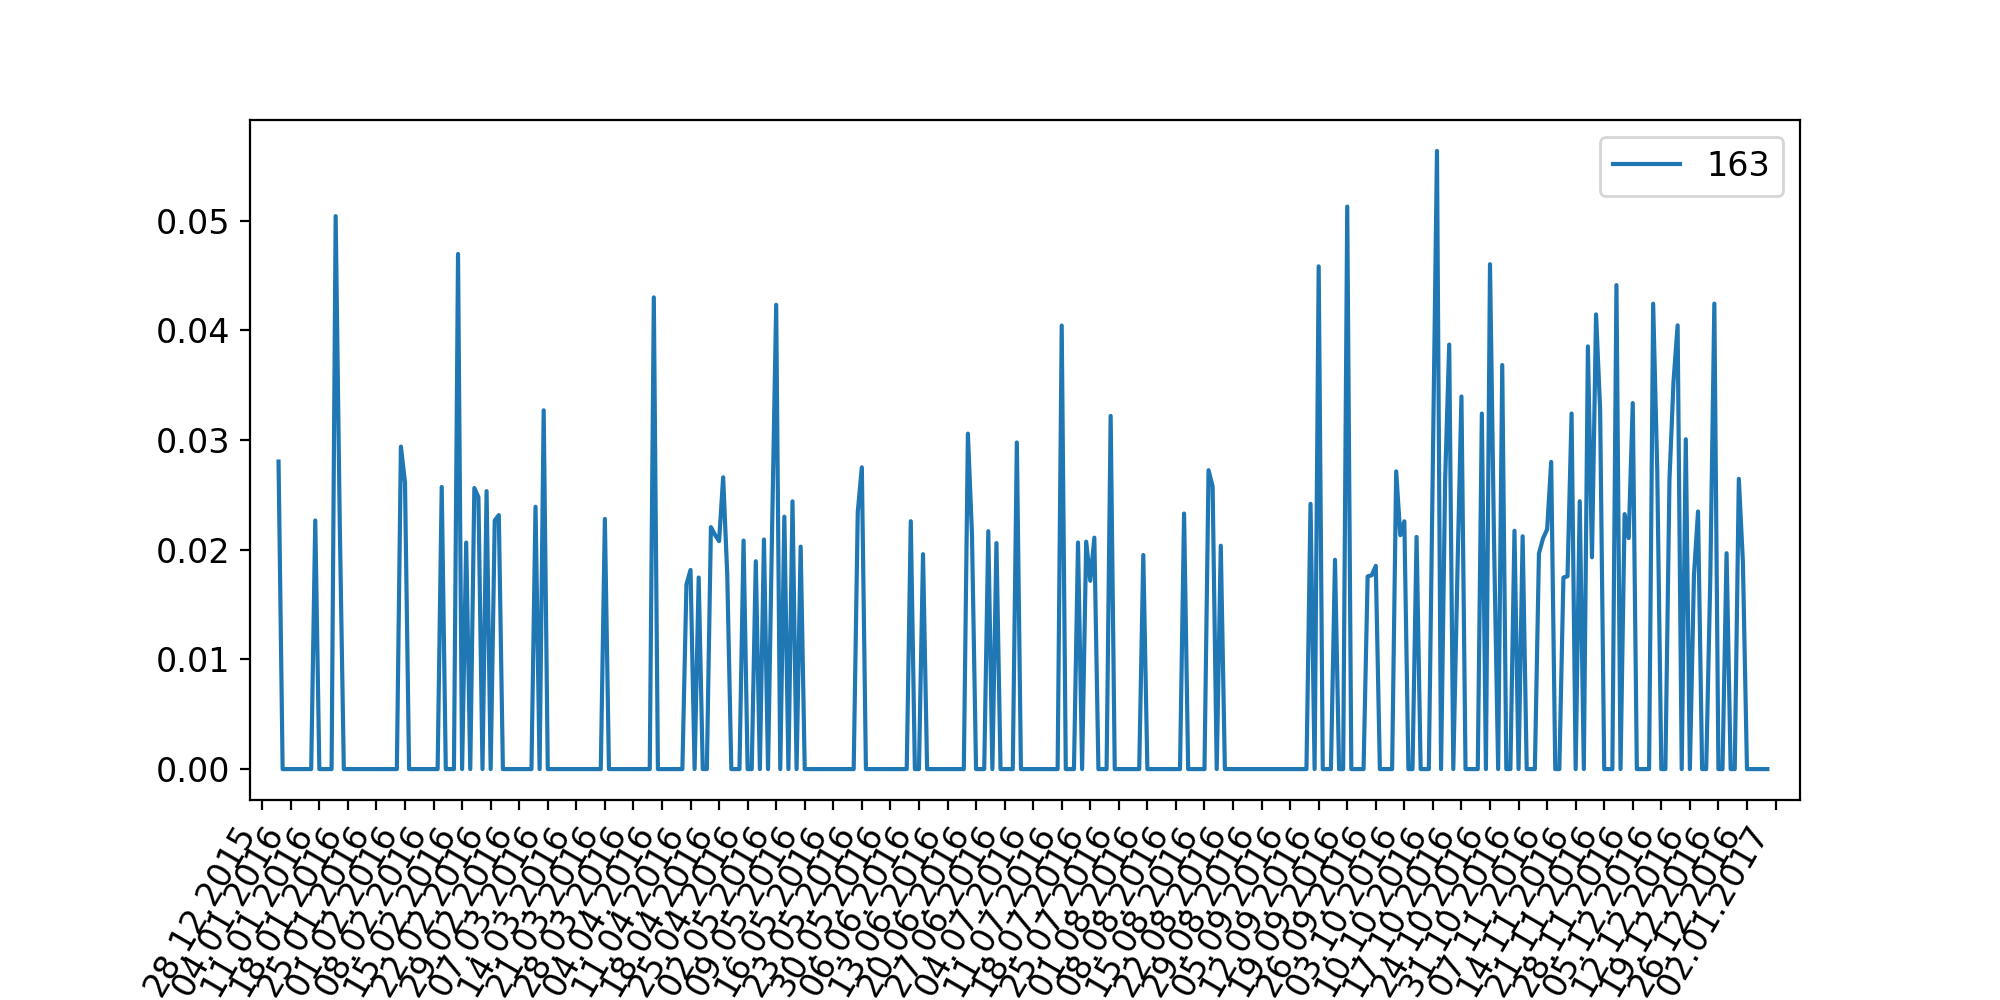

cluster: 163, 30 из 214 новостей:
	 Венер Галиев: дух воина присутствовал во мне всегда
	 Фёдор Емельяненко одержал победу над бразильцем Фабио Мальдонадо
	 Бокс: Эдуард Трояновский без церемоний отправил в нокаут претендента на свои чемпионские титулы
	 Ковалев прокомментировал поражение от Уорда
	 Боксер Ковалев победил Чилембу и защитил титулы чемпиона мира
	 Узбек Кадырова
	 Шотландский боксёр скончался в госпитале после нокаута на ринге
	 Кровавый спорт
	 Сергей Ковалев защитил три титула чемпиона мира по боксу
	 Сергей Ковалёв проиграл Андре Уорду бой года в Лас-Вегасе
	 Последний бой погибшего шотландского боксера попал на видео
	 Федор Емельяненко одержал верх над бразильцем Фабио Мальдонадо
	 Хабиб Нурмагомедов подписал контракт на бой с "очкариком" Фергюсоном
	 Боец UFC Нурмагомедов: Эй, ирландцы, я хочу драться с вашим сачком Макгрегором!
	 Сын Кости Цзю победил в дебютном бою на профессиональном ринге
	 Сергея Ковалёва назвали вторым среди самых впечатляющих боксёров соврем

<IPython.core.display.Javascript object>


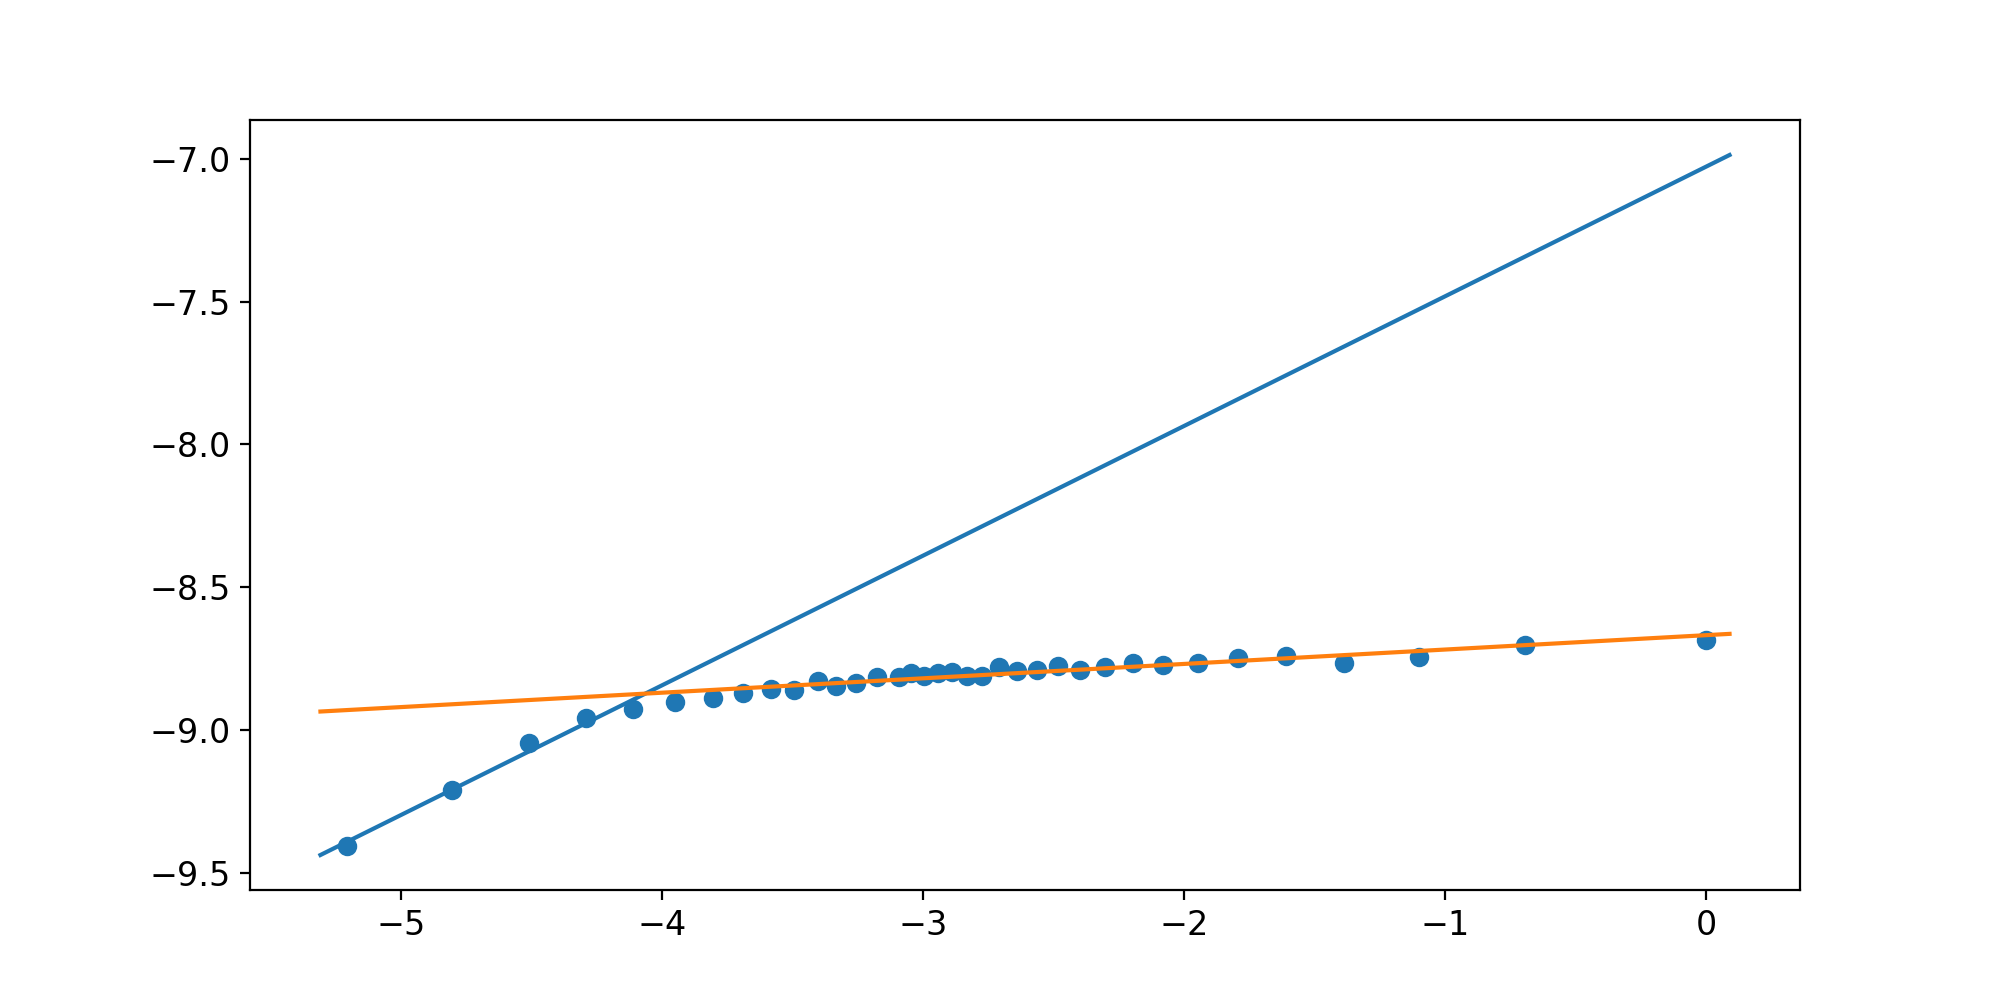

==1==
y = 0.453923930947 * x + -7.02752011176
correlation coefficient: 0.99215505452
h=0.773038034527
==2==
y = 0.0503562884691 * x + -8.66785291045
correlation coefficient: 0.95071627984
h=0.974821855765
----------------------
---График для кластера: 140


<IPython.core.display.Javascript object>


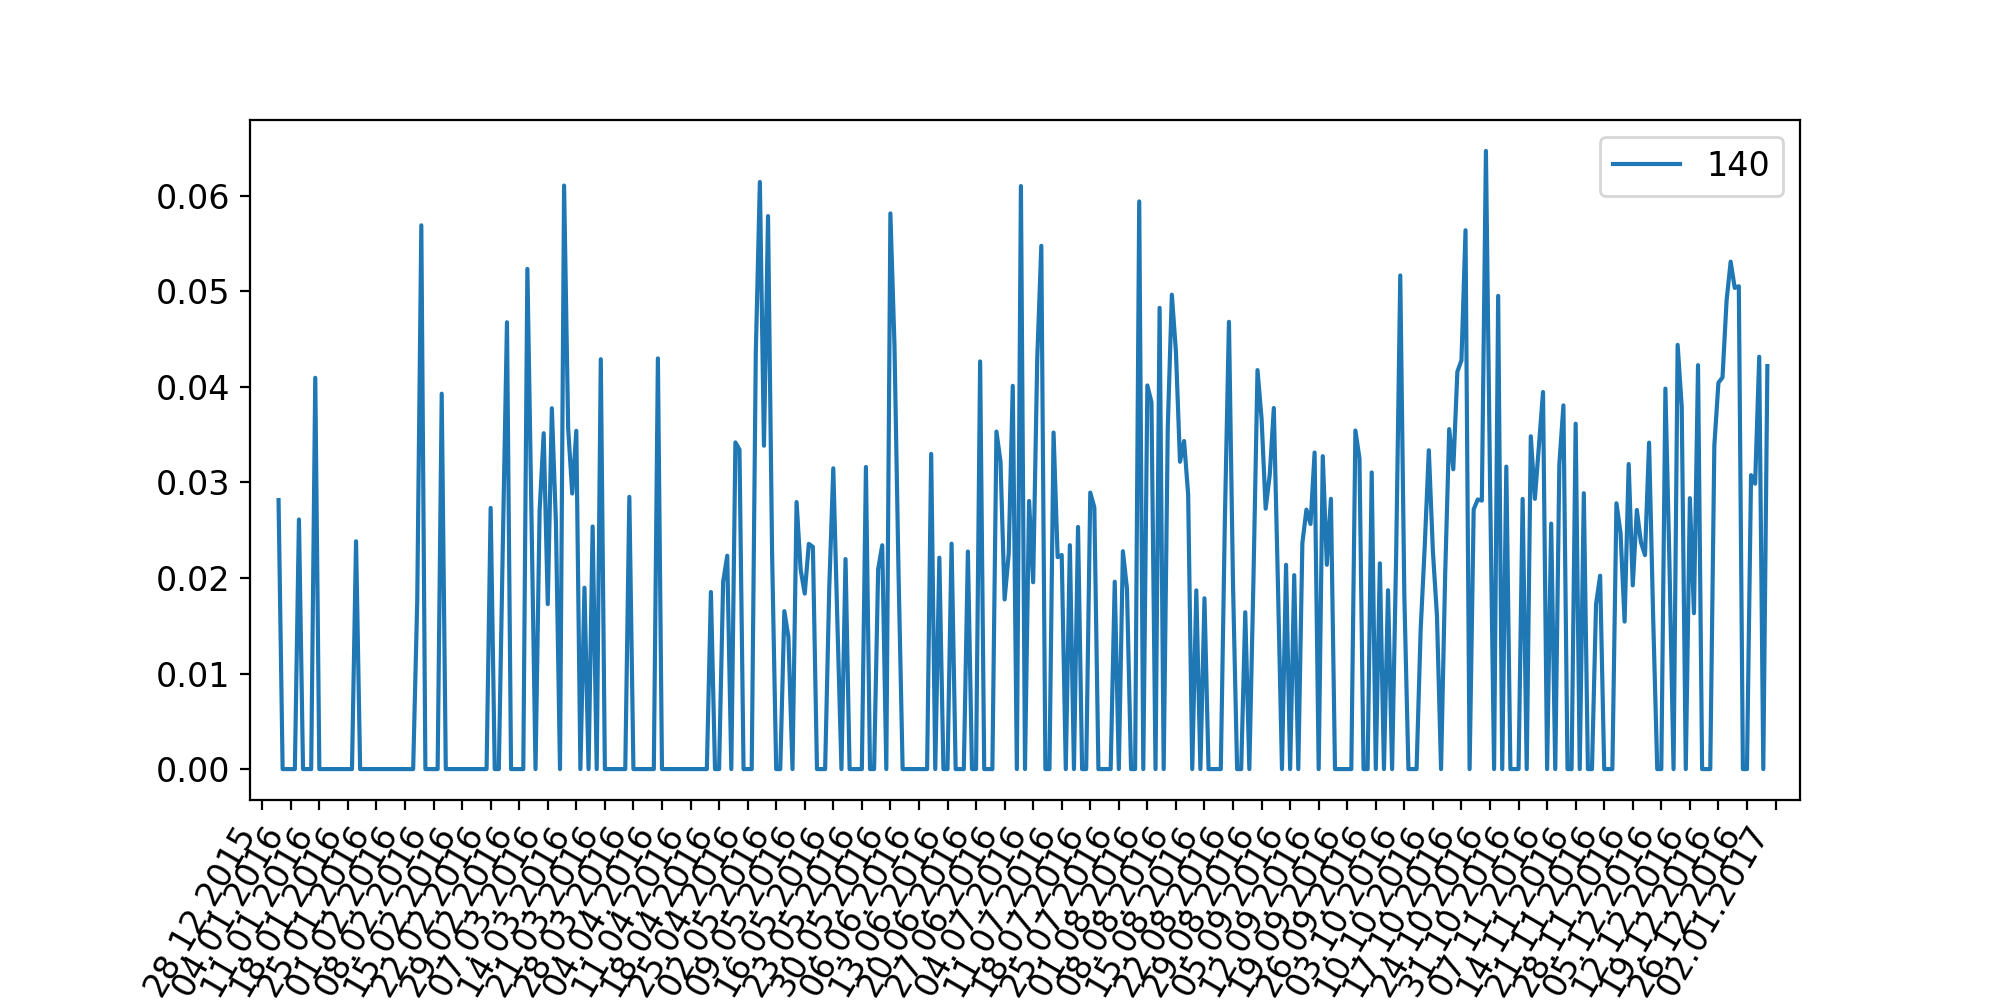

cluster: 140, 30 из 341 новостей:
	 ДНР: украинские силовики отступили с позиций, занятых в районе Дебальцево
	 ООН: Число жертв конфликта на Украине в июле стало рекордным за год
	 Лавров назвал Луганскую народную республику Лаосской
	 Украинские разведчики потеряли ноутбуки с агентурными данными
	 Плотницкий после покушения выступил с аудиообращением
	 В Минске достигнуто соглашение о разведении сторон на Донбассе
	 Украинский политик предложил брать россиян в заложники для обмена
	 ООН: число жертв в Донбассе впервые с 2015 года достигло пика
	 В Киеве оценили стоимость восстановления Донбасса в $15 млрд
	 Замглавы Спецмиссии ОБСЕ обсудил с Захарченко урегулирование в Донбассе
	 "Киборги" бьют по городам и селам ДНР с новой силой
	 Жители Горловки ночью подверглись мощному обстрелу со стороны ВСУ
	 Под шумок Олимпиады начнется новая война?
	 Бывший солдат ВСУ сдался российским пограничникам и попросил политического убежища
	 Спецслужбы ЛНР: Боевики нацбатов готовят масштабный теракт

<IPython.core.display.Javascript object>


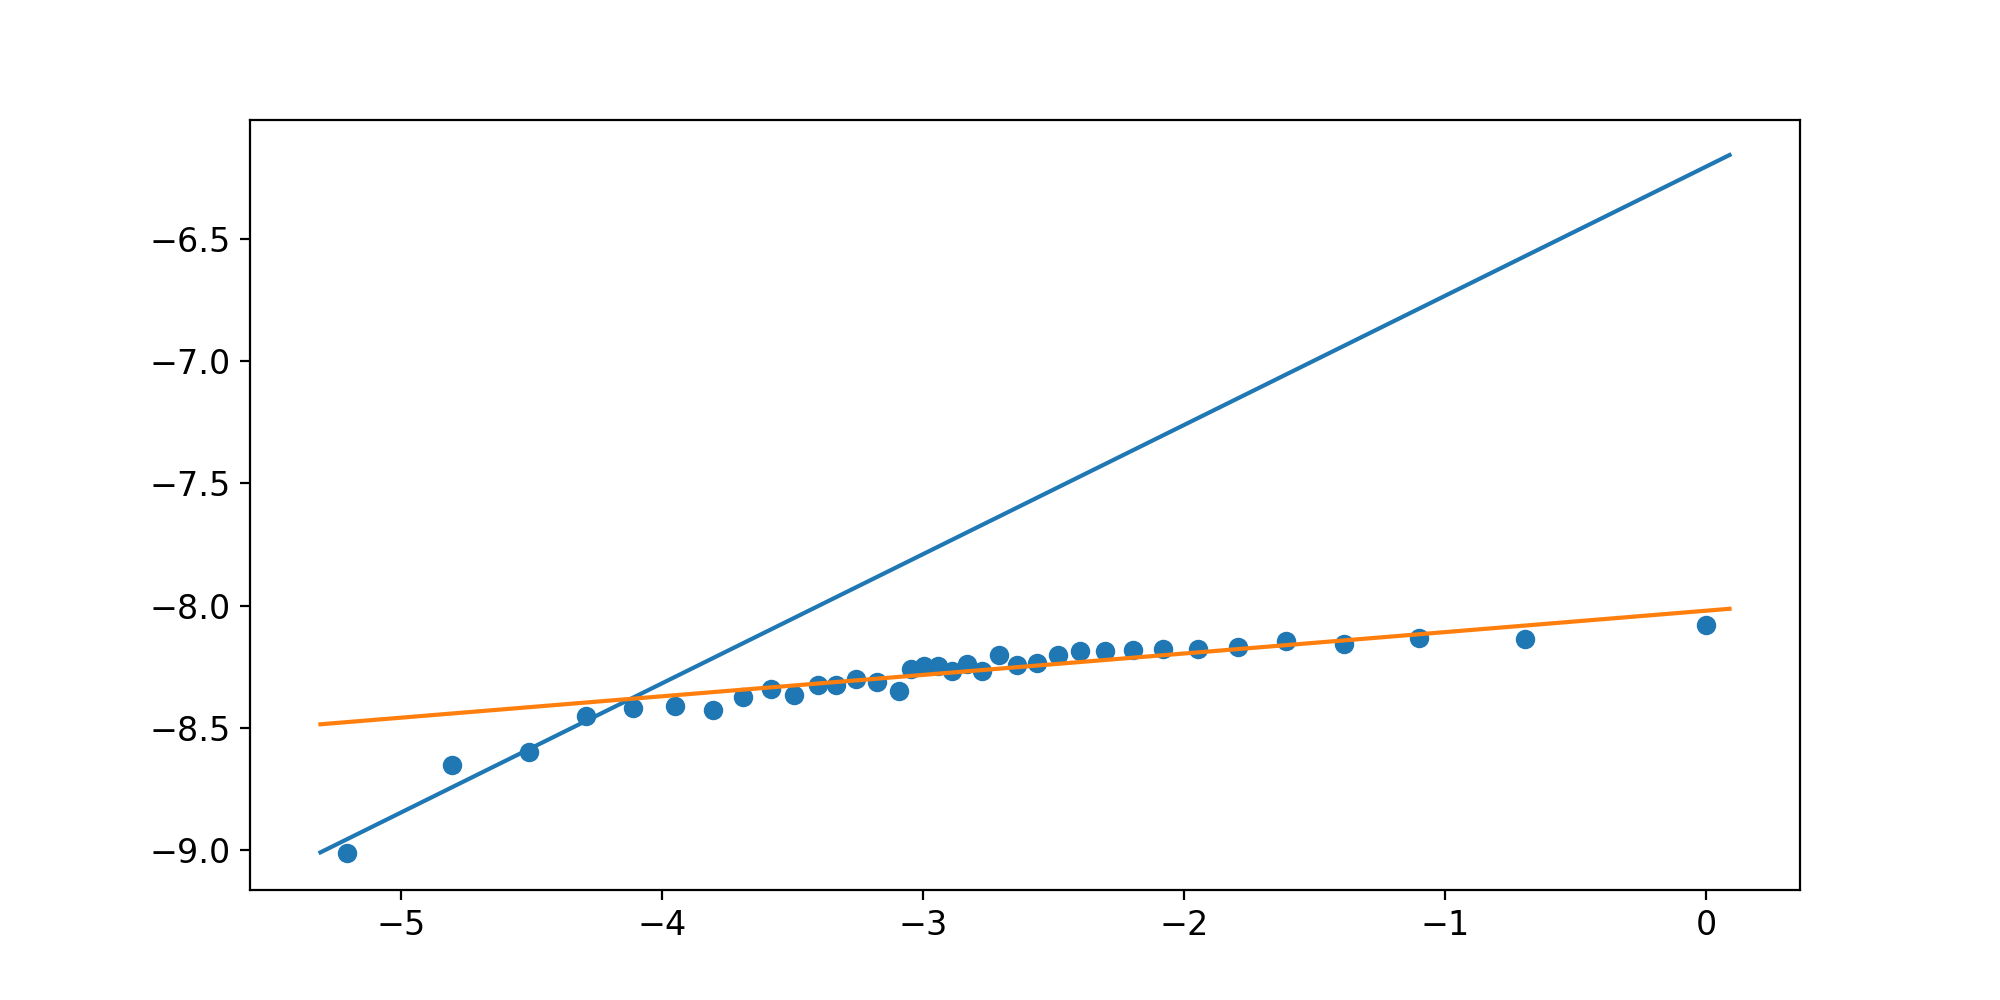

==1==
y = 0.52875317972 * x + -6.20314176488
correlation coefficient: 0.969474215526
h=0.73562341014
==2==
y = 0.0875666842546 * x + -8.02118280739
correlation coefficient: 0.922596515062
h=0.956216657873
----------------------
---График для кластера: 257


<IPython.core.display.Javascript object>


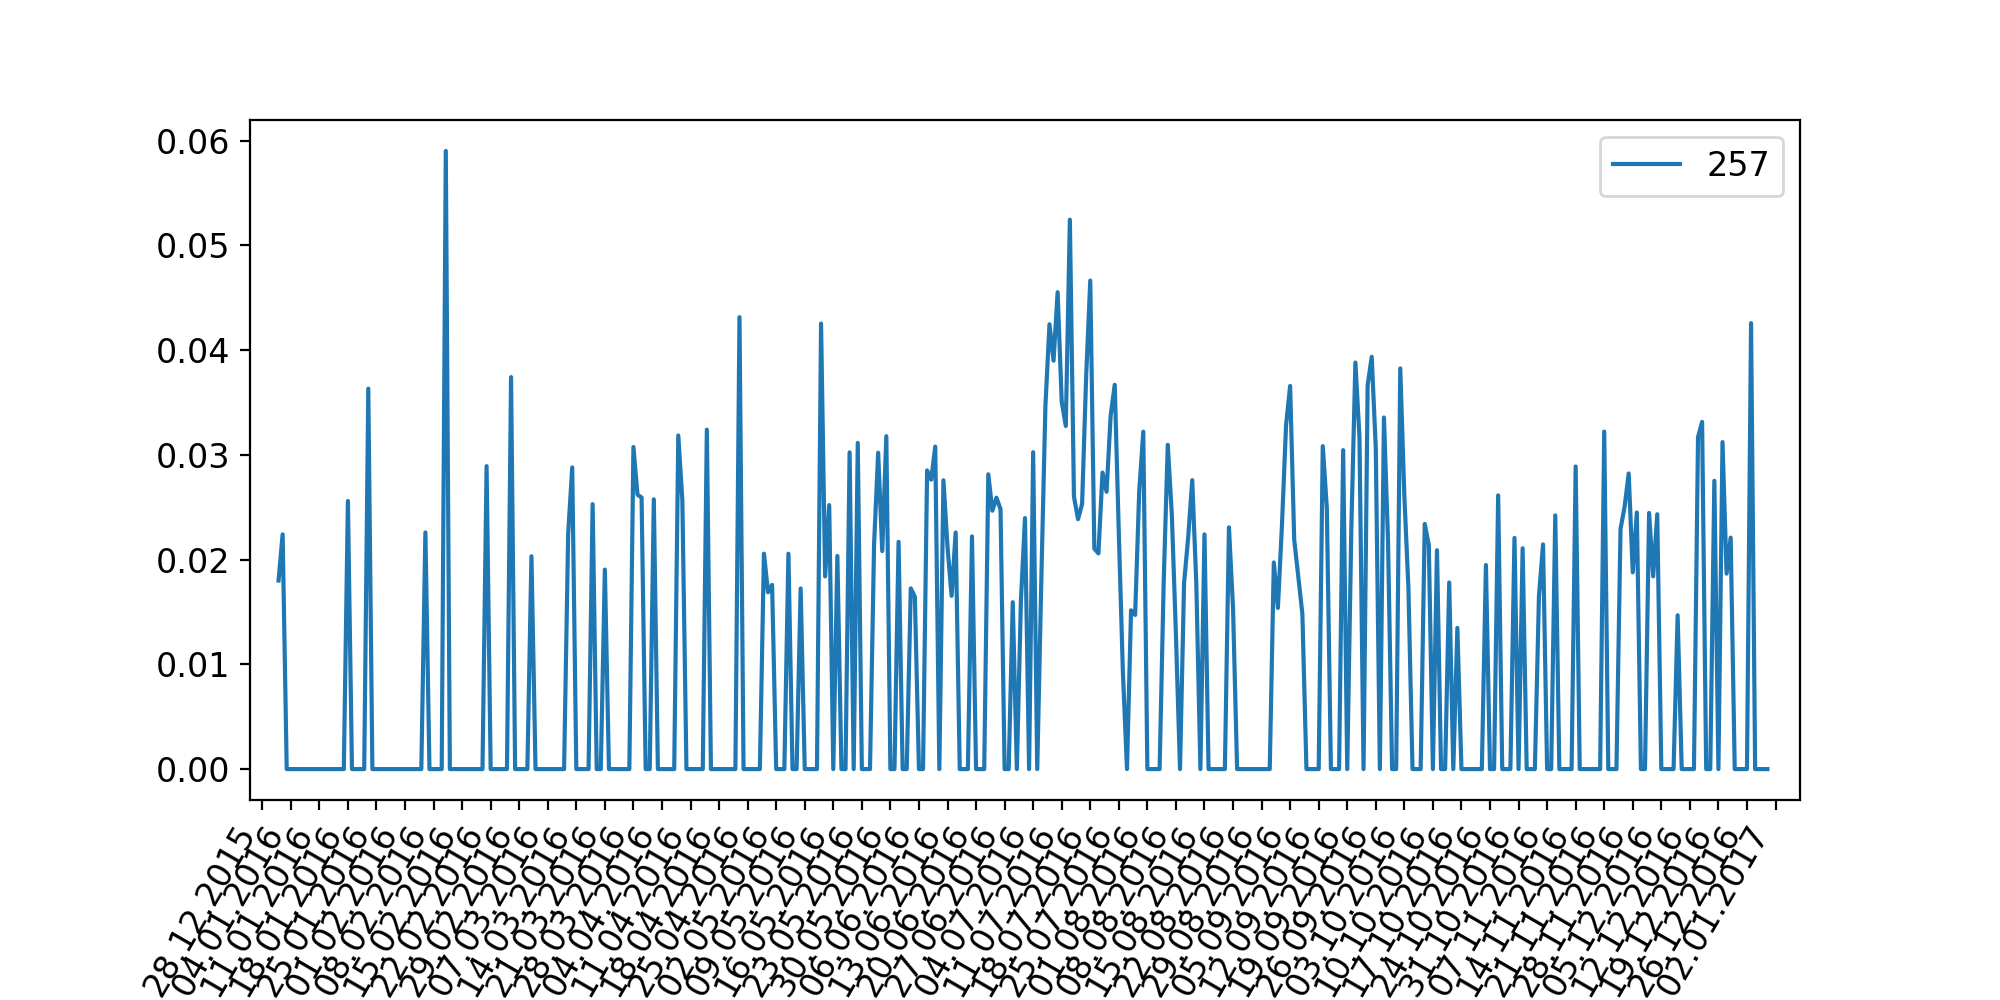

cluster: 257, 30 из 393 новостей:
	 Полиция Далласа получила новые угрозы о возможных атаках
	 Число погибших полицейских в результате беспорядков в Далласе выросло до пяти человек
	 Кунцевский стрелок, ранивший пять человек, покончил с собой
	 СМИ сообщили о множестве пострадавших в результате стрельбы в Денвере
	 "Американская история Х". Пять крупнейших бунтов против полиции в США
	 Полиция ликвидировала стрелявшего в кинотеатре на западе Германии
	 В Балтиморе полицейские застрелили напавшего на них мужчину
	 В США полицейские подстрелили чернокожего медика, который ловил сбежавшего пациента
	 Полицейский беспредел: в США отстреливают чернокожих
	 Неизвестный открыл стрельбу в Техасе: пострадало много людей
	 В ходе конфликта со стрельбой несколько человек ранены в жилом доме в Москве
	 Из автомобиля в Москве открыли стрельбу по прохожим
	 Бунт по-американски: пятерых полицейских расстреляли в Далласе
	 Чтобы расстрелять людей в Мюнхене, иранец прикинулся девушкой
	 В Техасе неизве

<IPython.core.display.Javascript object>


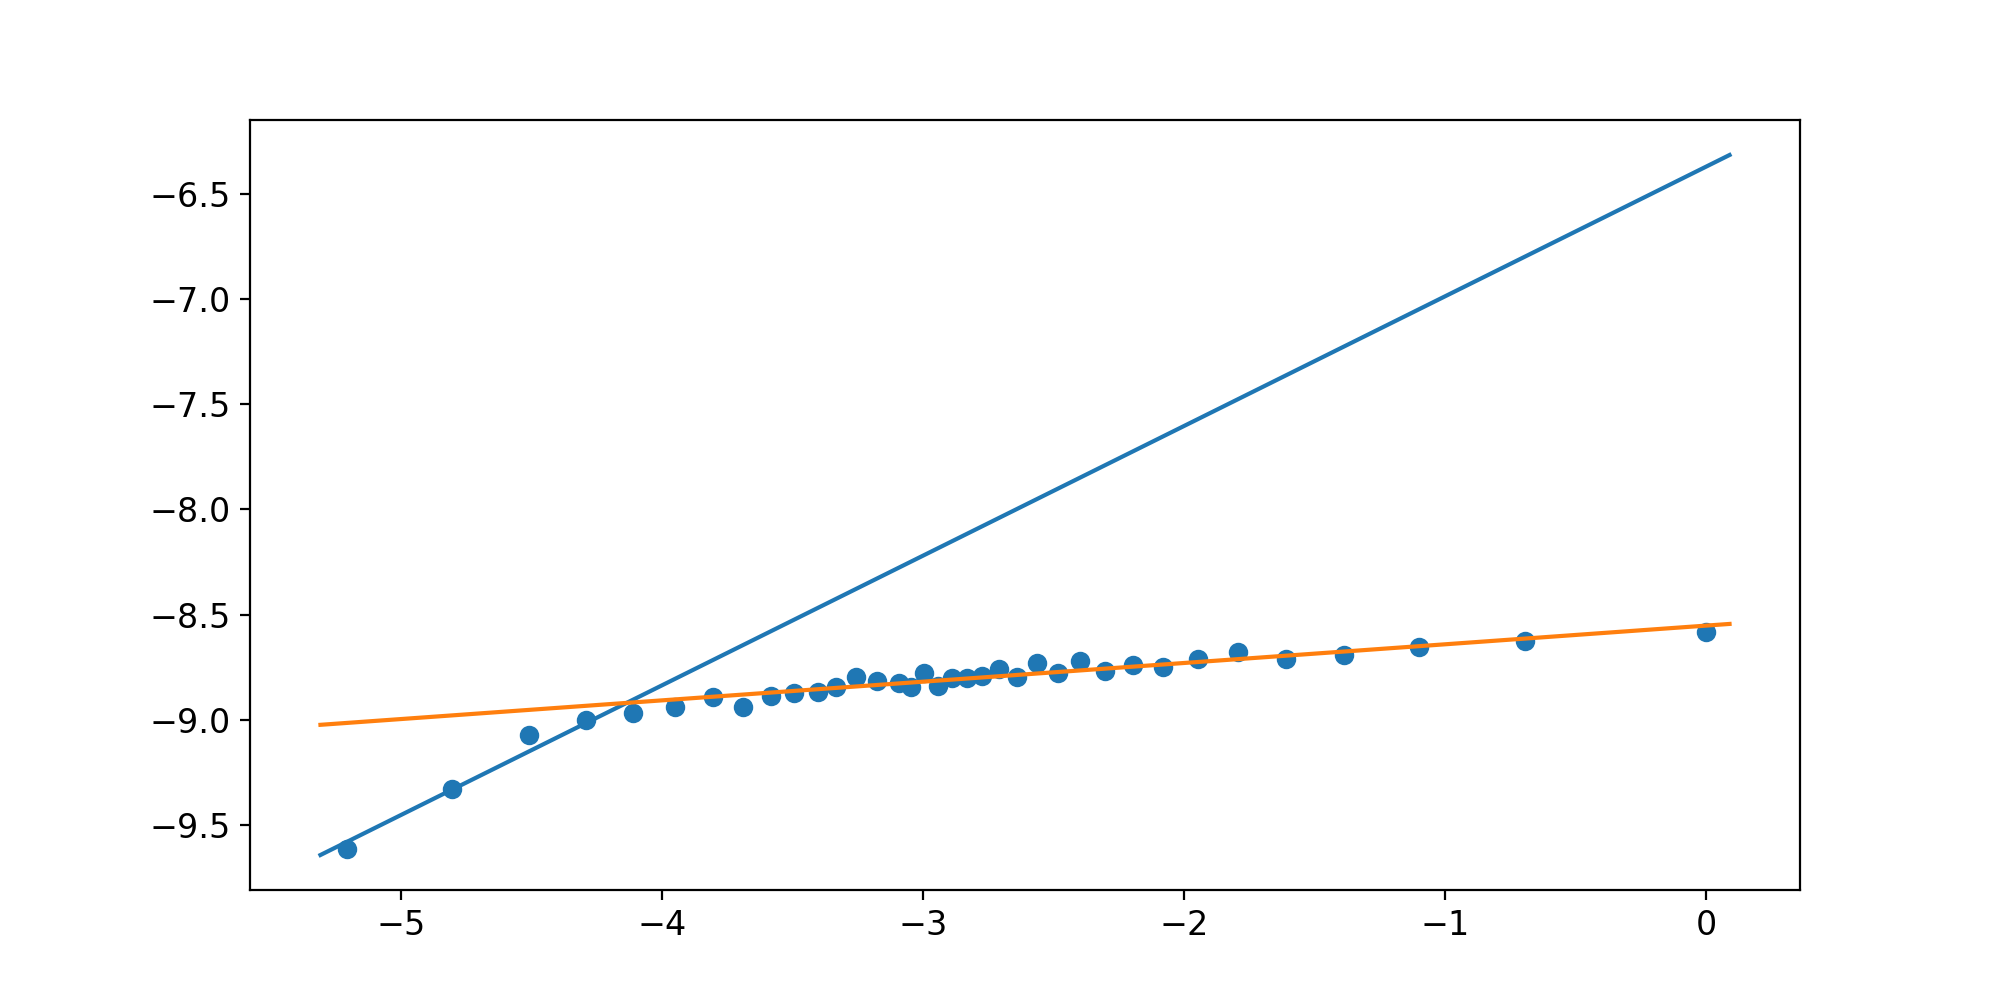

==1==
y = 0.616297842611 * x + -6.37103908069
correlation coefficient: 0.980292205266
h=0.691851078694
==2==
y = 0.0888213290069 * x + -8.55274063465
correlation coefficient: 0.954845498205
h=0.955589335497
----------------------
---График для кластера: 134


<IPython.core.display.Javascript object>


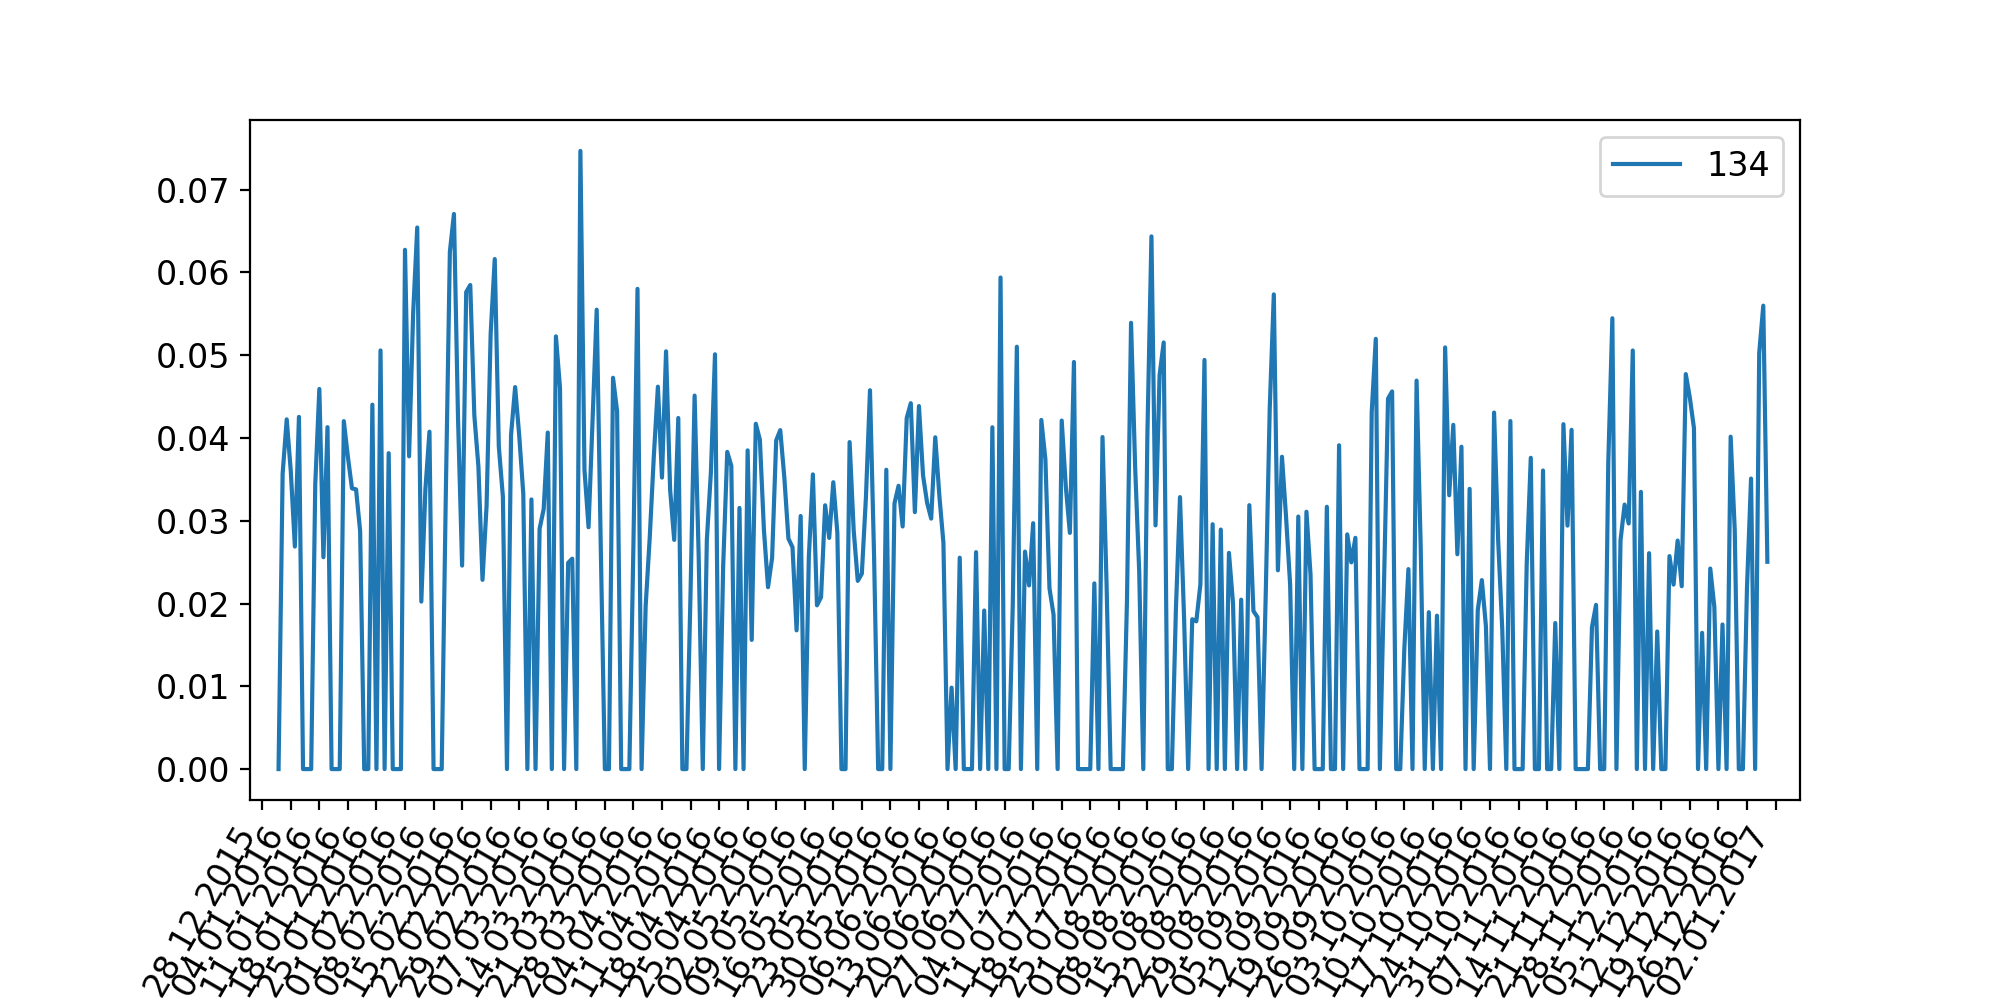

cluster: 134, 30 из 491 новостей:
	 Пентагон заявил о завершении операции против ИГИЛ в Ливии
	 Первые дни перемирия в Сирии: Минобороны РФ подвело итоги
	 В Кремле назвали отсутствие диалога с США причиной для активизации ИГИЛ в САР
	 Более 200 боевиков сложили оружие в сирийском Хомсе
	 ИГ применило химоружие против оппозиции на севере Сирии
	 Лайф публикует видео боя между боевиками ИГИЛ и армией Сирии близ Дейр-эз-Зора
	 Джихад в тени «Исламского государства»
	 Боевики в Алеппо обстреляли филологов. Один студент погиб
	 Захарова: Боевики и оружие попадают в Алеппо через турецко-сирийскую границу
	 Сирийская армия выбила боевиков ИГИЛ с высоты у Пальмиры
	 Путешественник Журавлев вернулся в Россию после трех лет плена у сирийских боевиков
	 В Нью-Йорке вывесили прославляющий Россию баннер
	 СМИ: ИГИЛ заявило о захвате пилота сирийского военного самолёта
	 На сторону восставших против ИГ жителей Ракки перешли 200 боевиков
	 Исламисты заживо сожгли 19 езидок за отказ от секса
	 "Джебх

<IPython.core.display.Javascript object>


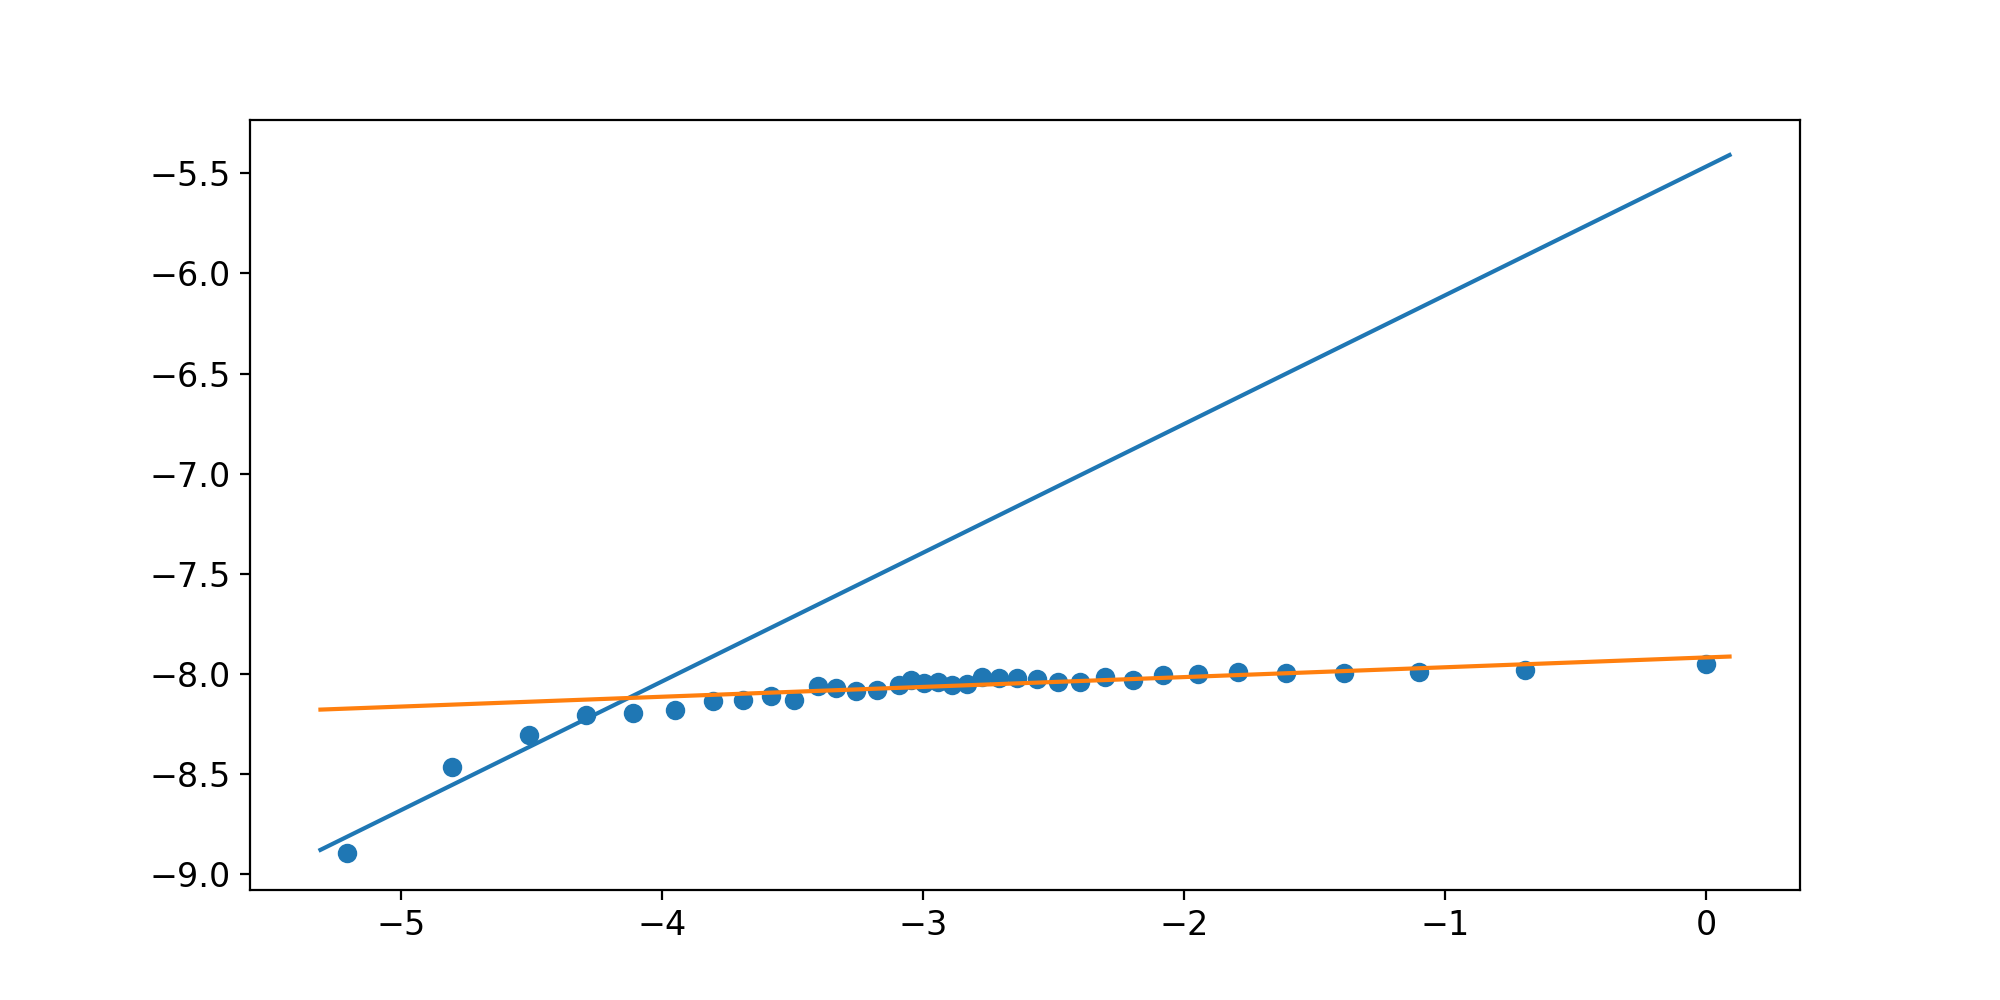

==1==
y = 0.643049895418 * x + -5.46605410252
correlation coefficient: 0.959784549889
h=0.678475052291
==2==
y = 0.0490911930691 * x + -7.91869678785
correlation coefficient: 0.882534610167
h=0.975454403465
----------------------


In [35]:
for c_label, c_news, dd_cos, h_res in best_res:
    print("---График для кластера: %s" % (c_label))
    plot_cos_centroid(dd_cos, start_year, end_year, c_label)
    print_news(c_news, 30, c_label)
    hist = SelfSimilarityHirst()
    h_res = hist.compute(list(dd_cos.items()))
    print("---Результаты анализа самоподобия кластера")
    h_res.print_result()
    h_res.plot()
    print("----------------------")